In [1]:
%matplotlib notebook
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import re
import math
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
import rosbag
from ros_numpy import numpify

In [2]:
def plot_trajectory(camera_pos=None, filtered_pos=None, true_pos=None, end=None, land=None):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    if camera_pos is not None:
        ax.plot(camera_pos[0], camera_pos[1], camera_pos[2], label='camera_pred', marker='o')
    if filtered_pos is not None:
        ax.plot(filtered_pos[0], filtered_pos[1], filtered_pos[2], label='filtered', marker='o')
    if true_pos is not None:
        ax.plot(true_pos[0], true_pos[1], true_pos[2], label='ground_truth')

    paddle_radius = .08

    if end is not None:
        p_end = Circle((end[0],end[2]), paddle_radius, fill=False)
        ax.add_patch(p_end)
        art3d.pathpatch_2d_to_3d(p_end, z=end[1], zdir="y")

    if land is not None:
        p_land = Circle(land[0:2], paddle_radius, fill=False)
        ax.add_patch(p_land)
        art3d.pathpatch_2d_to_3d(p_land, z=land[2], zdir="z")

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.xlim([-1.5,1.5])
    plt.ylim([-3,0])
    ax.set_zlim([0,3])
    ax.legend()

    plt.show()

In [3]:
file1 = open('camera.txt', 'r') 
lines = file1.readlines() 

In [4]:
x_camera = np.array([])
y_camera = np.array([])
z_camera = np.array([])
t_camera = np.array([])

for line in lines: 
    data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    if len(data) < 4:
        continue
    else:
        [x_temp,y_temp,z_temp,t_temp] = [float(data[0]),float(data[1]),float(data[2]),float(data[3])]
        x_camera = np.append(x_camera,x_temp)
        y_camera = np.append(y_camera,y_temp)
        z_camera = np.append(z_camera,z_temp)
        t_camera = np.append(t_camera,t_temp)
print("camera data size:", len(x_camera))
print("x_camera:", x_camera)

camera data size: 23
x_camera: [ 0.2247    0.2247    0.2247    0.2247    0.2247    0.219375  0.219375
  0.21405   0.21405   0.208725  0.2034    0.198075  0.19275   0.187425
  0.187425  0.19275   0.198075  0.2034    0.208725  0.208725  0.21405
  0.21405   0.21405 ]


In [5]:
file2 = open('true.yaml', 'r') 
lines2 = file2.readlines() 

In [6]:
x_true = np.array([])
y_true = np.array([])
z_true = np.array([])

for line in lines2: 
    data = re.findall(r"[-+]?\d*\.\d+|\d+", line)
    if len(data) < 3:
        continue
    else:
        [x_temp,y_temp,z_temp] = [float(data[0]),float(data[1]),float(data[2])]
        x_true = np.append(x_true,x_temp)
        y_true = np.append(y_true,y_temp)
        z_true = np.append(z_true,z_temp)
print("ground truth size:", len(x_true))
print("x_true:", x_true)

ground truth size: 39
x_true: [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


<IPython.core.display.Javascript object>


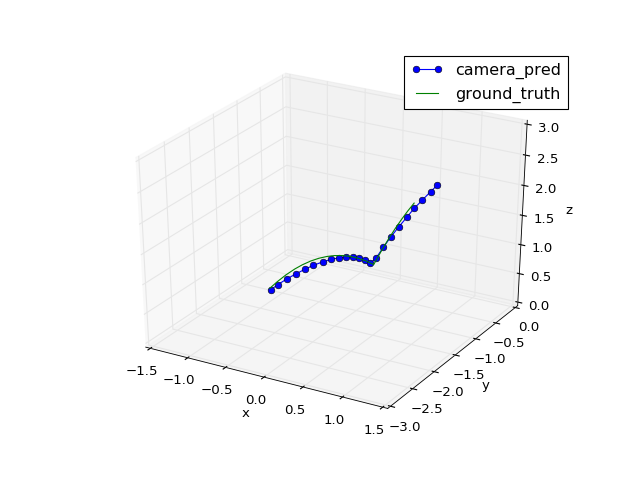

In [7]:
plot_trajectory(camera_pos=(x_camera, y_camera, z_camera), true_pos=(x_true, y_true, z_true))

In [8]:
mix_x = 0.5
mix_y = 0.5
mix_z = 0.5


def ema(pos,time,direction,mix_constant):
    acc = 0
    if direction == 'x' or direction == 'y':
        acc = 0;
    elif direction == 'z':
        acc = -9.81
    pos_filtered = np.array(pos[0:2])
    vel_filtered = np.array([(pos[1]-pos[0]) / (time[1]-time[0])])
    count_z = 0
    for i in range(2,len(time)):
        dt = time[i]-time[i-1]
        curVel = (pos[i]-pos[i-1]) / dt
        if direction == 'z' and curVel > 0 and count_z < 3:
            vel_filtered = np.append(vel_filtered,curVel)
            pos_filtered = np.append(pos_filtered,pos[i])
            count_z = count_z + 1
            continue
        predVel = vel_filtered[-1] + acc * dt
        estVel = (1-mix_constant) * predVel + mix_constant * curVel
        vel_filtered = np.append(vel_filtered,estVel)
        
        predPos = pos_filtered[-1] + vel_filtered[-2] * dt + 0.5 * acc * dt**2
        estPos = (1-mix_constant) * predPos + mix_constant * pos[i]
        pos_filtered = np.append(pos_filtered,estPos)
                             
    return pos_filtered, vel_filtered


# need at least N data points to precisely determine the end position and velocity
data_size = 22
[x_kalman,vx_kalman] = ema(x_camera[0:data_size], t_camera[0:data_size], 'x', mix_x)   
[y_kalman,vy_kalman] = ema(y_camera[0:data_size], t_camera[0:data_size], 'y', mix_y)  
[z_kalman,vz_kalman] = ema(z_camera[0:data_size], t_camera[0:data_size], 'z', mix_z)  

In [9]:

def predict(x,y,z,vx,vy,vz,t_initial):
    
    table_height = 0.76
    table_length = 2.74
    table_width = 1.525
    e = 0.4
    ball_radius = 0.02
    g = -9.81

    robot_pos_y = 0.5
    # define the end position of the ball in y-axis
    y_end = -0.15
    z_end = .90
    ws_radius = 1.6
    # squared value for the max x position that the robot can reach at the defined end y position
    x_limit_squared = ws_radius**2 - (abs(robot_pos_y) - abs(y_end))**2
    
    vx_end = vx
    vy_end = vy
    
    # check if the ball is not on the table initially
    if (z < table_height+ball_radius
            or abs(x) > table_width/2
            or abs(y) > table_length or y > 0):
        print('not on table\n')
        return

    #time for ball to reach the y end position
    t = abs(y - y_end) / vy
    t_end  = t_initial + t

    # check if the final x position is out of the robot workspace
    x_end = x + vx * t
    if x_end**2 > x_limit_squared:
        print("out of x-workspace")
        return

    # calculate the final z position
    print(z,vz,t)
    z_temp = z + vz * t + 0.5 * g * t**2
    if z_temp > table_height+ball_radius:
        # ball reaches the final y position without rebound
        #    set to hittable in case the initial state of the ball is after rebound
        z_end = z_temp
        vz_end = vz + g*t
        print("ball will not rebound, out of bounds\n")
        return [0,0,0],[x_end, y_end, z_end, vx_end, vy_end, vz_end, t_end],0

    else:
        # ball rebounds at least onece

        # find the time for the first rebound
        t_rb1 = (-vz - math.sqrt(vz**2 - 2 * g * (z - table_height - ball_radius))) / g
        # find the z velocity just before rebound
        vz_in = -math.sqrt(-2 * g * (z - table_height - ball_radius) + vz**2)
        # find the z velocity just after rebound
        vz_out = -e * vz_in

        # time until second rebound
        t_rb2 = 2 * vz_out / -g
        # time remains from the first rebound
        t_rem = t - t_rb1
        if t_rb2 < t_rem:
            # second rebound before reaching y end position
            # NOTE: this mothed may failed if z end position is too close to the table, may need an offset (t_rb2 < t_rem - 0.2?)
            # time till reaching goal z-position
            
            # Quadratic equation z_end = v_z t + .5 a * t^2
            discrim = np.sqrt(vz_out ** 2 + 2*(-g)*z_end)
            time1, time2 = (-vz_out + discrim)/(-g), (-vz_out - discrim)/(-g)
            t_hit = None
            choose1, choose2 = True, True
            # time of hit must occur after bounce
            # time of hit must occur before ball goes off table
            print("rebound more than once. quadratic solutions for hitting time:", time1, time2)
            if time1 < 0 or time1 > t_rem:
                choose1 = False
            if time2 < 0 or time2 > t_rem:
                choose2 = False
            if choose1 == False and choose2 == False:
                print("quadratic didn't find any valid solutions")
            elif choose1 == True and choose2 == True:
                print("quadratic has 2 valid solutions. First was chosen")
                t_hit = time1
            elif choose1 == True:
                t_hit = time1
            elif choose2 == True:
                t_hit = time2
            
            t_end = t_rb1 + t_hit
            vz_end = vz_out -g*t_hit
            return [x+vx_end*t_rb1, y+vy_end*t_rb1, table_height+ball_radius], [x+vx_end*t_end, y+vy_end*t_end, z_end, vx_end, vy_end, vz_end, t_end]
        else:
            z_end = z+vz_out*t_rem + 0.5*g*t_rem**2
            vz_end = vz_out + g*t_rem
            print("ball rebounds once and hittable\n")
            return [x+vx_end*t_rb1, y+vy_end*t_rb1, table_height+ball_radius], [x_end, y_end, z_end, vx_end, vy_end, vz_end, t_end]


In [10]:
predict_time = 10
land, end = predict(x_kalman[predict_time],y_kalman[predict_time],z_kalman[predict_time],vx_kalman[predict_time],vy_kalman[predict_time],vz_kalman[predict_time],t_camera[predict_time-1])
print(land, end)

1.16070224607 -2.97669224663 0.262788942225
ball rebounds once and hittable

[0.18915840667257985, -0.90604653239432964, 0.78] [0.16630180124193339, -0.15, 1.2933342922712494, -0.14813877394049754, 4.9001067411650645, 0.10281644536177303, 38.677788942225035]


<IPython.core.display.Javascript object>


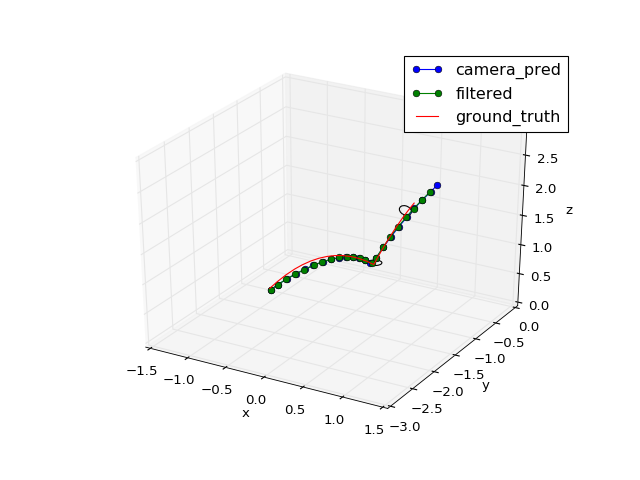

In [11]:
plot_trajectory(camera_pos=(x_camera, y_camera, z_camera), true_pos=(x_true, y_true, z_true), filtered_pos=(x_kalman, y_kalman, z_kalman), land=land, end=end)

In [12]:
end

[0.16630180124193339,
 -0.15,
 1.2933342922712494,
 -0.14813877394049754,
 4.9001067411650645,
 0.10281644536177303,
 38.677788942225035]

In [13]:
def to_numpy(msg):
    return np.array([msg.x, msg.y, msg.z])

In [14]:
def get_trajectories_from_bag(bagfile):
    bag = rosbag.Bag(bagfile)
    topics = ['/ball_detection/ball_pose', '/ball_detection/ball_state_filtered', '/ball_detection/ground_truth', '/ball_detection/predicted_ball_state']
    trajs = [[] for _ in range(len(topics))]
    for topic, msg, t in bag.read_messages():
        if topic == '/ball_detection/ball_pose':
            trajs[0].append(to_numpy(msg.point))
        elif topic in topics:
            i = topics.index(topic)
            trajs[i].append(to_numpy(msg.pos))
    return [np.array(t).T for t in trajs]

In [24]:
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-01-03-36.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-01-58-03.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-02-08-10.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-02-13-38.bag'
# bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-02-24-36.bag'
# bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-02-33-16.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-03-43-26.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-03-44-36.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-20-41-43.bag'
bagfile = '/home/ashwin/table-tennis-robot/bags/ball_2020-12-10-20-45-35.bag'
trajs = get_trajectories_from_bag(bagfile)
print([t.shape for t in trajs])

[(3, 40), (3, 39), (3, 819), (3, 39)]


In [25]:
print(trajs[3].T)
first_predict = 0
for i in range(len(trajs[3].T)):
    if trajs[3][0,i] != 0:
        first_predict = i
        break
print("First predicted state:", i)

[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.13676809 -0.15        1.05474603]
 [ 0.11906445 -0.15        0.92734317]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.        

<IPython.core.display.Javascript object>


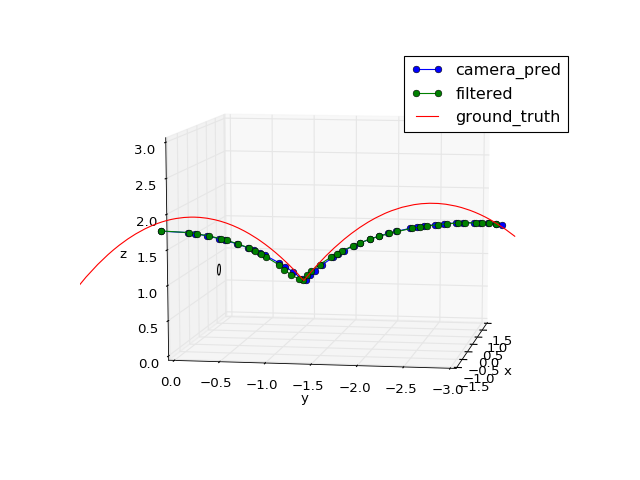

In [27]:
plot_trajectory(trajs[0], trajs[1], trajs[2], end=trajs[3][:,first_predict+1])